# Using Unfold.jl from Python

Unfold.jl can be called from Python using the JuliaCall package. In the following, you can find instruction for installing the required packages and an example of using Unfold to fit a regression model on an MNE example data set.

## Installation & Setup

In [ ]:
# Install JuliaCall, MNE-Python, Seaborn and Pandas in the current Jupyter kernel
import sys
!{sys.executable} -m pip install juliacall
!{sys.executable} -m pip install mne
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas

In [ ]:
# Import the Julia package manager
from juliacall import Pkg as jlPkg

# Activate the environment in the current folder
jlPkg.activate(".")

# Check the status of the environment/installed packages -> will be empty at the beginning
print(jlPkg.status())

Note: If you want to specify which Julia version or package versions should be used, then create a file called `juliapkg.json` (See details [here](https://docs.juliahub.com/PythonCall/WdXsa/0.9.3/juliacall/#julia-deps)).

In [ ]:
# Install Julia packages (in the activated environment)
jlPkg.add("Unfold")
jlPkg.add("DataFrames")

## Import required Julia and Python packages

In [4]:
# Load Julia's Main module
from juliacall import Main as jl

In [5]:
# Import DataFrames and Unfold
# The function seval() can be used to evaluate a piece of Julia code given as a string
jl.seval("using DataFrames")
jl.seval("using Unfold")

In [6]:
# Import required Pythin packages
from mne.datasets.limo import load_data
import pandas as pd
import seaborn as sns

## Load example data set

In [ ]:
## Load an MNE example dataset for regression

# Specify location for the data set
data_path = "."

# Load data for first subject
epoched = load_data(subject=1, path=data_path)

# Resample data at 128 Hz to speed up model fitting
epoched.resample(128)

# Extract events, eeg data and times
evts = epoched.metadata
data  = epoched.get_data(units=dict(eeg="uV",eog="uV")).transpose((1,2,0))
times = epoched.times

## Fit Unfold model

In [8]:
# Specify model formula
formula = jl.seval("@formula 0~1+phaseCoh")

# Transfer events data frame from Pandas DataFrame to Julia DataFrame
evts_df = jl.DataFrame(face=evts["face"].values,phaseCoh=evts["phase-coherence"].values)

# Fit Unfold model
m = jl.Unfold.fit(jl.Unfold.UnfoldModel,formula,evts_df,data,times)

# Extract coefficient table
results_jl = jl.Unfold.coeftable(m)

# Transfer results back to Python
results_py = pd.DataFrame({'channel': results_jl.channel,
                           'coefname': results_jl.coefname,
                           'estimate': results_jl.estimate,
                           'time': results_jl.time})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Visualise the modelling results

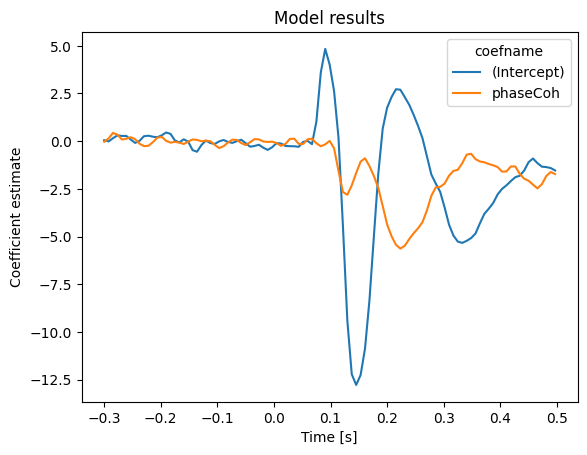

In [9]:
# Extract the coefficients for one channel
results_ch43 = results_py[results_py.channel == 43]

# Plot the coefficient estimates over time
ax = sns.lineplot(x = results_ch43.time,y=results_ch43.estimate,hue=results_ch43.coefname)
ax.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Model results');